# Fine-tuning Test with FineTuner

This notebook demonstrates simplified fine-tuning using the `FineTuner` class.
Uses 3000 high-confidence PSMs for both training and evaluation.


## 1. Setup and Imports


In [1]:
%reload_ext autoreload
%autoreload 2
from alpharaw import register_all_readers
from dia_aspire_rescore.io import read_diann2
import matplotlib.pyplot as plt
from dia_aspire_rescore.psm.matcher import DIAPeptideSpectrumMatcher
from dia_aspire_rescore.config import FineTuneConfig
from dia_aspire_rescore.finetuning import FineTuner
from peptdeep.model.ms2 import calc_ms2_similarity
import warnings
from pathlib import Path
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
register_all_readers()



/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/alpharaw/raw_access/pysciexwifffilereader.py:44: UserWarning: Dotnet-based dependencies could not be loaded. Sciex support is disabled.
  warnings.warn(
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/alpharaw/raw_access/pythermorawfilereader.py:35: UserWarning: Dotnet-based dependencies could not be loaded. Thermo support is disabled.
  warnings.warn(


## 2. Load, Filter and Sample Data


In [2]:
psm_df_all = read_diann2("../data/raw/SYS026_RA957/DDA_SYSMHC_bynam/lib-base-result-first-pass.parquet")
psm_df_filtered = psm_df_all[psm_df_all['fdr1_search1'] < 0.01].copy()
psm_df_sample = psm_df_filtered[0:3000].sort_values(by='nAA', ascending=True).reset_index(drop=True)

## 3. Match MS2 Spectra


In [3]:
matcher = DIAPeptideSpectrumMatcher(n_neighbors=0)

ms_files = {
    '20200317_QE_HFX2_LC3_DIA_RA957_R01': './output/20200317_QE_HFX2_LC3_DIA_RA957_R01.mzML.hdf5',
    '20200317_QE_HFX2_LC3_DIA_RA957_R02': './output/20200317_QE_HFX2_LC3_DIA_RA957_R02.mzML.hdf5'
}

psm_df, fragment_mz_df, matched_intensity_df, matched_mz_err_df = matcher.match_ms2_multi_raw(
    psm_df_sample,
    ms_files,
    'hdf5'
)

100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


In [4]:
psm_df_sample

,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,fdr1_search1,fdr2_search1,fdr1_search2,fdr2_search2,mods,mod_sites,nAA,rt_norm,precursor_mz,ccs
0,20200317_QE_HFX2_LC3_DIA_RA957_R02,FRPDNFVF,2,95.554832,95.400719,95.738922,0.0,1/sp|Q13885|TBB2A_HUMAN,1/sp|Q13885|TBB2A_HUMAN,,...,0.003205,0.000124,0.0,0.0,,,8,0.799000,521.261259,0.0
1,20200317_QE_HFX2_LC3_DIA_RA957_R02,FHSELPVL,2,91.970909,91.877678,92.155983,0.0,1/sp|Q99567|NUP88_HUMAN,1/sp|Q99567|NUP88_HUMAN,,...,0.000087,0.000124,0.0,0.0,,,8,0.769033,471.258185,0.0
2,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHSELPVL,2,92.015205,91.891205,92.138687,0.0,1/sp|Q99567|NUP88_HUMAN,1/sp|Q99567|NUP88_HUMAN,,...,0.000087,0.000124,0.0,0.0,,,8,0.768826,471.258185,0.0
3,20200317_QE_HFX2_LC3_DIA_RA957_R02,FHSHLPEL,2,63.616238,63.431465,63.864765,0.0,1/sp|A6NHJ4|ZN860_HUMAN,1/sp|A6NHJ4|ZN860_HUMAN,,...,0.003520,0.009531,0.0,0.0,,,8,0.531940,490.253434,0.0
4,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHSHLPEL,2,63.506447,63.383774,63.660061,0.0,1/sp|A6NHJ4|ZN860_HUMAN,1/sp|A6NHJ4|ZN860_HUMAN,,...,0.003520,0.009531,0.0,0.0,,,8,0.530623,490.253434,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,20200317_QE_HFX2_LC3_DIA_RA957_R01,DHVSTYAA,2,30.744476,30.620783,30.867432,0.0,1/sp|P20036|DPA1_HUMAN,1/sp|P20036|DPA1_HUMAN,,...,0.000835,0.000124,0.0,0.0,,,8,0.256883,432.198325,0.0
2996,20200317_QE_HFX2_LC3_DIA_RA957_R02,DHVSTYAA,2,30.437326,30.343361,30.562054,0.0,1/sp|P20036|DPA1_HUMAN,1/sp|P20036|DPA1_HUMAN,,...,0.000835,0.000124,0.0,0.0,,,8,0.254508,432.198325,0.0
2997,20200317_QE_HFX2_LC3_DIA_RA957_R01,DHVSTYAA,1,30.793379,30.638924,30.885572,0.0,1/sp|P20036|DPA1_HUMAN,1/sp|P20036|DPA1_HUMAN,,...,0.000087,0.000124,0.0,0.0,,,8,0.257292,863.389373,0.0
2998,20200317_QE_HFX2_LC3_DIA_RA957_R02,DHYGLPAV,2,75.337029,75.152519,75.551758,0.0,1/sp|Q13772|NCOA4_HUMAN,1/sp|Q13772|NCOA4_HUMAN,,...,0.000087,0.000124,0.0,0.0,,,8,0.629945,436.219060,0.0


## 4. Create and Save Configuration


In [ ]:
# Create configuration
config = FineTuneConfig(
    instrument='QE',
    nce=27,
    psm_num_to_train_ms2=3000,
    epoch_to_train_ms2=20,
    psm_num_to_train_rt_ccs=3000,
    epoch_to_train_rt_ccs=20,
    train_verbose=True,
    thread_num=8
)


output_dir = Path('../tests/test_data/finetuning')
output_dir.mkdir(parents=True, exist_ok=True)
# config.to_yaml(str(output_dir / 'config.yaml'))
print("\nConfiguration:")
for key, value in config.to_dict().items():
    print(f"  {key}: {value}")



Configuration:
  instrument: QE
  nce: 27
  mask_modloss: True
  device: None
  psm_num_to_train_ms2: 3000
  psm_num_to_test_ms2: 0
  epoch_to_train_ms2: 20
  warmup_epoch_to_train_ms2: 10
  batch_size_to_train_ms2: 512
  lr_to_train_ms2: 0.0001
  psm_num_per_mod_to_train_ms2: 50
  top_n_mods_to_train: 10
  psm_num_to_train_rt_ccs: 3000
  epoch_to_train_rt_ccs: 20
  warmup_epoch_to_train_rt_ccs: 10
  batch_size_to_train_rt_ccs: 1024
  lr_to_train_rt_ccs: 0.0001
  psm_num_per_mod_to_train_rt_ccs: 50
  train_verbose: True
  thread_num: 8


## 5. RT Fine-tuning


In [6]:
# Initialize FineTuner
finetuner = FineTuner(config)
finetuner.load_pretrained('generic')

In [7]:
# Prepare RT evaluation data (group by peptide sequence)
psm_df_rt = psm_df.groupby(['sequence', 'mods', 'mod_sites'])[['rt_norm']].median().reset_index()
print(f"Unique peptides for RT: {len(psm_df_rt)}")

# Evaluate BEFORE fine-tuning
print("\n" + "=" * 70)
print("RT Model - BEFORE Fine-tuning")
print("=" * 70)

rt_test_before = finetuner.test_rt_model(psm_df_rt)
print("\nTest statistics:")
print(rt_test_before)

psm_df_rt_pred_before = finetuner.predict_rt(psm_df_rt.copy())
rt_errors_before = (psm_df_rt_pred_before['rt_pred'] - psm_df_rt_pred_before['rt_norm']).abs()
print(f"\nPrediction errors:")
print(f"  MAE: {rt_errors_before.mean():.4f}")
print(f"  Median: {rt_errors_before.median():.4f}")
print(f"  R_square: {rt_test_before['R_square'].values[0]:.4f}")


Unique peptides for RT: 1289

RT Model - BEFORE Fine-tuning

Test statistics:
   R_square        R     slope  intercept  test_num
0  0.936966  0.96797  0.920806   0.183061      1289
2025-11-22 18:23:09> Predicting RT ...


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


Prediction errors:
  MAE: 0.1563
  Median: 0.1498
  R_square: 0.9370


In [8]:
print("\n" + "=" * 70)
print("Fine-tuning RT Model...")
print("=" * 70)
finetuner.train_rt(psm_df)


Fine-tuning RT Model...
2025-11-22 18:23:09> 1289 PSMs for RT model training/transfer learning
2025-11-22 18:23:09> Training with fixed sequence length: 0
[Training] Epoch=1, lr=2e-05, loss=0.1550501585006714
[Training] Epoch=2, lr=3e-05, loss=0.15502865612506866
[Training] Epoch=3, lr=4e-05, loss=0.15206008404493332
[Training] Epoch=4, lr=5e-05, loss=0.15055599063634872
[Training] Epoch=5, lr=6e-05, loss=0.14776989817619324
[Training] Epoch=6, lr=7e-05, loss=0.14462191611528397
[Training] Epoch=7, lr=8e-05, loss=0.13929231464862823
[Training] Epoch=8, lr=9e-05, loss=0.1347261518239975
[Training] Epoch=9, lr=0.0001, loss=0.12729508057236671
[Training] Epoch=10, lr=0.0001, loss=0.12291504442691803
[Training] Epoch=11, lr=9.755282581475769e-05, loss=0.11484305560588837
[Training] Epoch=12, lr=9.045084971874738e-05, loss=0.10854968056082726
[Training] Epoch=13, lr=7.938926261462366e-05, loss=0.09813957288861275
[Training] Epoch=14, lr=6.545084971874738e-05, loss=0.09115661680698395
[Trai

In [9]:
# Evaluate AFTER fine-tuning
print("\n" + "=" * 70)
print("RT Model - AFTER Fine-tuning")
print("=" * 70)

rt_test_after = finetuner.test_rt_model(psm_df_rt)
print("\nTest statistics:")
print(rt_test_after)

psm_df_rt_pred_after = finetuner.predict_rt(psm_df_rt.copy())
rt_errors_after = (psm_df_rt_pred_after['rt_pred'] - psm_df_rt_pred_after['rt_norm']).abs()
print(f"\nPrediction errors:")
print(f"  MAE: {rt_errors_after.mean():.4f}")
print(f"  Median: {rt_errors_after.median():.4f}")
print(f"  R_square: {rt_test_after['R_square'].values[0]:.4f}")

# Improvement
print("\n" + "=" * 70)
print("RT Improvement")
print("=" * 70)
print(f"MAE: {rt_errors_before.mean():.4f} -> {rt_errors_after.mean():.4f} (Δ: {rt_errors_after.mean() - rt_errors_before.mean():+.4f})")
print(f"R_square: {rt_test_before['R_square'].values[0]:.4f} -> {rt_test_after['R_square'].values[0]:.4f}")



RT Model - AFTER Fine-tuning

Test statistics:
   R_square         R     slope  intercept  test_num
0  0.933475  0.966165  0.864581   0.128607      1289
2025-11-22 18:23:15> Predicting RT ...


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


Prediction errors:
  MAE: 0.0726
  Median: 0.0637
  R_square: 0.9335

RT Improvement
MAE: 0.1563 -> 0.0726 (Δ: -0.0837)
R_square: 0.9370 -> 0.9335


## 6. MS2 Fine-tuning


In [10]:
# Predict MS2 BEFORE fine-tuning
print("\n" + "=" * 70)
print("MS2 Model - BEFORE Fine-tuning")
print("=" * 70)

psm_df_ms2_before = psm_df.copy()
intensity_before = finetuner.predict_ms2(psm_df_ms2_before.sort_values(by='nAA', ascending=True).reset_index(drop=True))

intensity_before


MS2 Model - BEFORE Fine-tuning
2025-11-22 18:23:15> Predicting MS2 ...


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


,b_z1,b_z2,y_z1,y_z2
0,0.000000,0.0,0.000000,0.0
1,0.288728,0.0,0.000000,0.0
2,0.062698,0.0,0.000000,0.0
3,0.207845,0.0,0.000000,0.0
4,1.000000,0.0,0.033197,0.0
...,...,...,...,...
20995,0.259798,0.0,0.000000,0.0
20996,0.552896,0.0,0.000000,0.0
20997,1.000000,0.0,0.163559,0.0
20998,0.007872,0.0,0.106264,0.0


In [11]:
psm_df

,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,fdr2_search2,mods,mod_sites,nAA,rt_norm,precursor_mz,ccs,frag_start_idx,frag_stop_idx,spec_idx
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHSELPVL,2,92.015205,91.891205,92.138687,0.0,1/sp|Q99567|NUP88_HUMAN,1/sp|Q99567|NUP88_HUMAN,,...,0.0,,,8,0.768826,471.258185,0.0,14,21,68246
1,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHSHLPEL,2,63.506447,63.383774,63.660061,0.0,1/sp|A6NHJ4|ZN860_HUMAN,1/sp|A6NHJ4|ZN860_HUMAN,,...,0.0,,,8,0.530623,490.253434,0.0,28,35,46926
2,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHSIASVL,2,82.680122,82.587814,82.772392,0.0,1/sp|Q5TBA9|FRY_HUMAN,1/sp|Q5TBA9|FRY_HUMAN,,...,0.0,,,8,0.690828,437.245078,0.0,42,49,61275
3,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHQSSSLL,2,57.876316,57.753208,58.030006,0.0,1/sp|Q9NXT0|ZN586_HUMAN,1/sp|Q9NXT0|ZN586_HUMAN,,...,0.0,,,8,0.483581,459.737617,0.0,63,70,42715
4,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHQVSEVL,1,65.154495,65.031815,65.277054,0.0,1/sp|Q8N543|OGFD1_HUMAN,1/sp|Q8N543|OGFD1_HUMAN,,...,0.0,,,8,0.544394,958.499258,0.0,77,84,48183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,20200317_QE_HFX2_LC3_DIA_RA957_R02,DHYGLPAV,1,75.355179,75.139946,75.569893,0.0,1/sp|Q13772|NCOA4_HUMAN,1/sp|Q13772|NCOA4_HUMAN,,...,0.0,,,8,0.630097,871.430844,0.0,20930,20937,55702
2996,20200317_QE_HFX2_LC3_DIA_RA957_R02,DHVTATQL,2,44.210789,44.055317,44.335335,0.0,1/sp|P50851|LRBA_HUMAN,1/sp|P50851|LRBA_HUMAN,,...,0.0,,,8,0.369677,442.727249,0.0,20944,20951,32526
2997,20200317_QE_HFX2_LC3_DIA_RA957_R02,DHVTATQL,1,44.197666,44.073509,44.322346,0.0,1/sp|P50851|LRBA_HUMAN,1/sp|P50851|LRBA_HUMAN,,...,0.0,,,8,0.369567,884.447222,0.0,20958,20965,32519
2998,20200317_QE_HFX2_LC3_DIA_RA957_R02,DHVSTYAA,2,30.437326,30.343361,30.562054,0.0,1/sp|P20036|DPA1_HUMAN,1/sp|P20036|DPA1_HUMAN,,...,0.0,,,8,0.254508,432.198325,0.0,20972,20979,22336


In [12]:
psm_df

,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,fdr2_search2,mods,mod_sites,nAA,rt_norm,precursor_mz,ccs,frag_start_idx,frag_stop_idx,spec_idx
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHSELPVL,2,92.015205,91.891205,92.138687,0.0,1/sp|Q99567|NUP88_HUMAN,1/sp|Q99567|NUP88_HUMAN,,...,0.0,,,8,0.768826,471.258185,0.0,14,21,68246
1,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHSHLPEL,2,63.506447,63.383774,63.660061,0.0,1/sp|A6NHJ4|ZN860_HUMAN,1/sp|A6NHJ4|ZN860_HUMAN,,...,0.0,,,8,0.530623,490.253434,0.0,28,35,46926
2,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHSIASVL,2,82.680122,82.587814,82.772392,0.0,1/sp|Q5TBA9|FRY_HUMAN,1/sp|Q5TBA9|FRY_HUMAN,,...,0.0,,,8,0.690828,437.245078,0.0,42,49,61275
3,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHQSSSLL,2,57.876316,57.753208,58.030006,0.0,1/sp|Q9NXT0|ZN586_HUMAN,1/sp|Q9NXT0|ZN586_HUMAN,,...,0.0,,,8,0.483581,459.737617,0.0,63,70,42715
4,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHQVSEVL,1,65.154495,65.031815,65.277054,0.0,1/sp|Q8N543|OGFD1_HUMAN,1/sp|Q8N543|OGFD1_HUMAN,,...,0.0,,,8,0.544394,958.499258,0.0,77,84,48183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,20200317_QE_HFX2_LC3_DIA_RA957_R02,DHYGLPAV,1,75.355179,75.139946,75.569893,0.0,1/sp|Q13772|NCOA4_HUMAN,1/sp|Q13772|NCOA4_HUMAN,,...,0.0,,,8,0.630097,871.430844,0.0,20930,20937,55702
2996,20200317_QE_HFX2_LC3_DIA_RA957_R02,DHVTATQL,2,44.210789,44.055317,44.335335,0.0,1/sp|P50851|LRBA_HUMAN,1/sp|P50851|LRBA_HUMAN,,...,0.0,,,8,0.369677,442.727249,0.0,20944,20951,32526
2997,20200317_QE_HFX2_LC3_DIA_RA957_R02,DHVTATQL,1,44.197666,44.073509,44.322346,0.0,1/sp|P50851|LRBA_HUMAN,1/sp|P50851|LRBA_HUMAN,,...,0.0,,,8,0.369567,884.447222,0.0,20958,20965,32519
2998,20200317_QE_HFX2_LC3_DIA_RA957_R02,DHVSTYAA,2,30.437326,30.343361,30.562054,0.0,1/sp|P20036|DPA1_HUMAN,1/sp|P20036|DPA1_HUMAN,,...,0.0,,,8,0.254508,432.198325,0.0,20972,20979,22336


In [13]:
psm_df_ms2_before, metrics_before = calc_ms2_similarity(
    psm_df_ms2_before,
    intensity_before,
    matched_intensity_df,
    metrics=['PCC', 'COS', 'SA', 'SPC']
)

print("\nMS2 Similarity Metrics (Before):")
print(metrics_before)

print("\nTarget PSMs mean:")
target_before = psm_df_ms2_before[psm_df_ms2_before['decoy'] == 0]
for metric in ['PCC', 'COS', 'SA', 'SPC']:
    print(f"  {metric}: {target_before[metric].mean():.4f}")


MS2 Similarity Metrics (Before):
               PCC          COS           SA          SPC
count  3000.000000  3000.000000  3000.000000  3000.000000
mean      0.201810     0.342245     0.230770    -0.069256
std       0.252942     0.214086     0.156127     0.414859
min      -0.302482     0.000000     0.000000    -1.409962
25%      -0.001911     0.169480     0.108418    -0.338533
50%       0.158801     0.311408     0.201601    -0.021894
75%       0.373696     0.490975     0.326719     0.231253
max       0.982950     0.983215     0.883193     0.969349
>0.90     0.005000     0.005667     0.000000     0.001667
>0.75     0.028667     0.045333     0.003000     0.010333

Target PSMs mean:
  PCC: 0.2027
  COS: 0.3433
  SA: 0.2315
  SPC: -0.0686


In [14]:
# Fine-tune MS2 model
finetuner.train_ms2(psm_df, matched_intensity_df)


2025-11-22 18:23:17> 3000 PSMs for MS2 model training/transfer learning
2025-11-22 18:23:17> Training with fixed sequence length: 0
[Training] Epoch=1, lr=2e-05, loss=0.08767521008849144
[Training] Epoch=2, lr=3e-05, loss=0.08277741198738416
[Training] Epoch=3, lr=4e-05, loss=0.07463851819435756
[Training] Epoch=4, lr=5e-05, loss=0.0662378544608752
[Training] Epoch=5, lr=6e-05, loss=0.06146077128748099
[Training] Epoch=6, lr=7e-05, loss=0.05839405643443266
[Training] Epoch=7, lr=8e-05, loss=0.056270778800050415
[Training] Epoch=8, lr=9e-05, loss=0.05439698323607445
[Training] Epoch=9, lr=0.0001, loss=0.052986400201916695
[Training] Epoch=10, lr=0.0001, loss=0.05214203894138336
[Training] Epoch=11, lr=9.755282581475769e-05, loss=0.05137143780787786
[Training] Epoch=12, lr=9.045084971874738e-05, loss=0.050851850459973015
[Training] Epoch=13, lr=7.938926261462366e-05, loss=0.05025525391101837
[Training] Epoch=14, lr=6.545084971874738e-05, loss=0.04991580918431282
[Training] Epoch=15, lr=5

In [ ]:
# Predict MS2 AFTER fine-tuning
print("\n" + "=" * 70)
print("MS2 Model - AFTER Fine-tuning")
print("=" * 70)

psm_df_ms2_after = psm_df_sample.copy()
intensity_after = finetuner.predict_ms2(psm_df_ms2_after)

# Calculate similarity metrics
psm_df_ms2_after, metrics_after = calc_ms2_similarity(
    psm_df_ms2_after,
    intensity_after,
    matched_intensity_df,
    charged_frag_types=None,
    metrics=['PCC', 'COS', 'SA', 'SPC']
)

print("\nMS2 Similarity Metrics (After):")
print(metrics_after)

print("\nTarget PSMs mean:")
target_after = psm_df_ms2_after[psm_df_ms2_after['decoy'] == 0]
for metric in ['PCC', 'COS', 'SA', 'SPC']:
    print(f"  {metric}: {target_after[metric].mean():.4f}")

# Improvement
print("\n" + "=" * 70)
print("MS2 Improvement")
print("=" * 70)
for metric in ['PCC', 'COS', 'SA', 'SPC']:
    before_val = target_before[metric].mean()
    after_val = target_after[metric].mean()
    print(f"{metric}: {before_val:.4f} -> {after_val:.4f} (Δ: {after_val - before_val:+.4f})")

intensity_after


MS2 Model - AFTER Fine-tuning
2025-11-22 18:24:03> Predicting MS2 ...


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


MS2 Similarity Metrics (After):
               PCC          COS           SA          SPC
count  3000.000000  3000.000000  3000.000000  3000.000000
mean      0.837859     0.863435     0.740737     0.624175
std       0.246668     0.212287     0.232411     0.276731
min      -0.091120     0.000000     0.000000    -0.752600
25%       0.802730     0.843525     0.639047     0.490148
50%       0.959075     0.967084     0.836207     0.676382
75%       0.989196     0.990970     0.914384     0.824165
max       0.999589     0.999618     0.982406     1.000000
>0.90     0.650667     0.683667     0.312000     0.137333
>0.75     0.780667     0.808667     0.636667     0.376667

Target PSMs mean:
  PCC: 0.8458
  COS: 0.8703
  SA: 0.7473
  SPC: 0.6324

MS2 Improvement
PCC: 0.2027 -> 0.8458 (Δ: +0.6431)
COS: 0.3433 -> 0.8703 (Δ: +0.5269)
SA: 0.2315 -> 0.7473 (Δ: +0.5158)
SPC: -0.0686 -> 0.6324 (Δ: +0.7010)


,b_z1,b_z2,y_z1,y_z2
0,0.000000,0.000000,0.000000,0.0
1,0.058611,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.0
3,0.106317,0.000000,0.000000,0.0
4,0.438193,0.023958,0.000000,0.0
...,...,...,...,...
20995,0.004132,0.000000,0.869001,0.0
20996,0.022724,0.000000,0.131871,0.0
20997,0.092658,0.000000,0.012464,0.0
20998,0.160363,0.000000,1.000000,0.0


## 7. Save Test Data


# Save all data
print("Saving test data to:", output_dir)

psm_df.to_parquet(output_dir / 'psm_df.parquet', index=False)
print(f"✓ psm_df.parquet ({len(psm_df):,} rows)")

matched_intensity_df.to_parquet(output_dir / 'matched_intensity.parquet')
print(f"✓ matched_intensity.parquet {matched_intensity_df.shape}")

fragment_mz_df.to_parquet(output_dir / 'fragment_mz_df.parquet')
print(f"✓ fragment_mz_df.parquet {fragment_mz_df.shape}")



## 8. Visualization


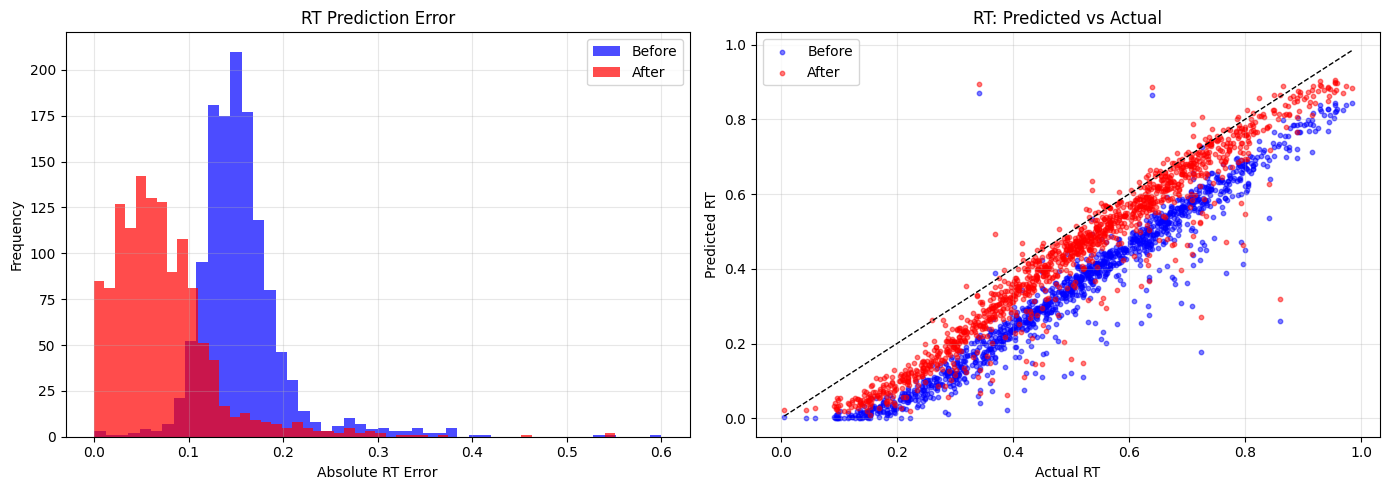

In [17]:
# RT comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(rt_errors_before, bins=50, alpha=0.7, label='Before', color='blue')
axes[0].hist(rt_errors_after, bins=50, alpha=0.7, label='After', color='red')
axes[0].set_xlabel('Absolute RT Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title('RT Prediction Error')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(psm_df_rt_pred_before['rt_norm'], psm_df_rt_pred_before['rt_pred'], 
                alpha=0.5, s=10, label='Before', color='blue')
axes[1].scatter(psm_df_rt_pred_after['rt_norm'], psm_df_rt_pred_after['rt_pred'], 
                alpha=0.5, s=10, label='After', color='red')
axes[1].plot([psm_df_rt['rt_norm'].min(), psm_df_rt['rt_norm'].max()],
             [psm_df_rt['rt_norm'].min(), psm_df_rt['rt_norm'].max()],
             'k--', linewidth=1)
axes[1].set_xlabel('Actual RT')
axes[1].set_ylabel('Predicted RT')
axes[1].set_title('RT: Predicted vs Actual')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


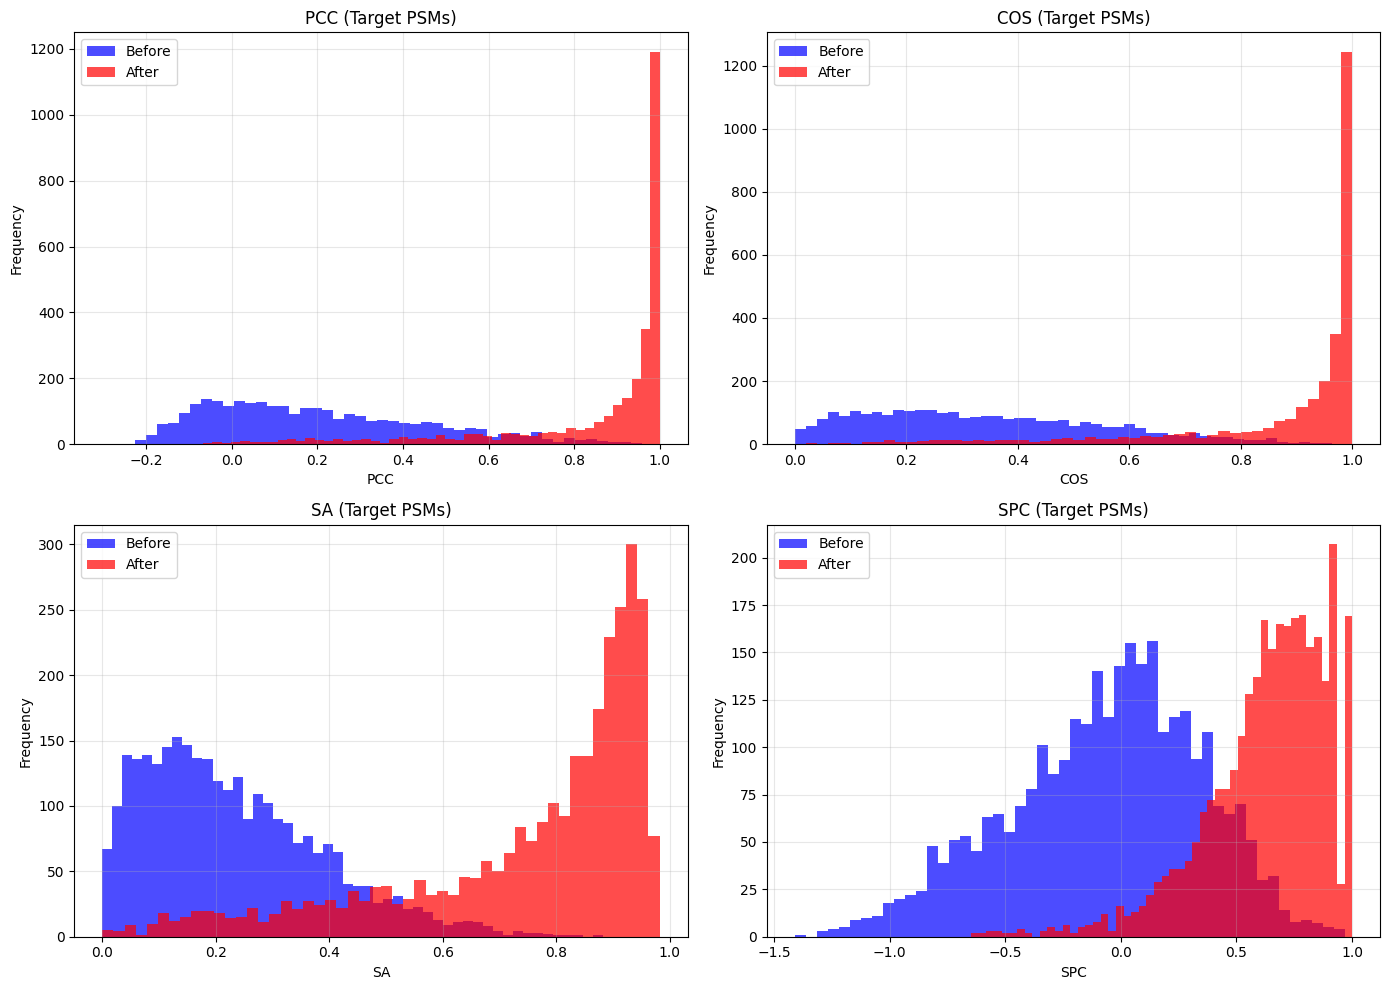

In [18]:
# MS2 comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, metric in enumerate(['PCC', 'COS', 'SA', 'SPC']):
    ax = axes[idx // 2, idx % 2]
    
    before_vals = target_before[metric].values
    after_vals = target_after[metric].values
    
    ax.hist(before_vals, bins=50, alpha=0.7, label='Before', color='blue')
    ax.hist(after_vals, bins=50, alpha=0.7, label='After', color='red')
    ax.set_xlabel(metric)
    ax.set_ylabel('Frequency')
    ax.set_title(f'{metric} (Target PSMs)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
